In [52]:
## This was our first try of the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def process_data(data):
    data['departure_date'] = pd.to_datetime(data['departure_date'])
    data['booking_date'] = pd.to_datetime(data['booking_date'])
    data['days_prior'] = (data['departure_date'] - data['booking_date']).dt.days
    data['week_day'] = data['departure_date'].dt.day_name()
    data['final_demand'] = data.groupby('departure_date')['cum_bookings'].transform(max)
    return data

def additive_model(training_data, validation_data):
    # Fine-tune the calculation of avg_remaining_demand
    training_data['avg_remaining_demand'] = (
        training_data.groupby(['days_prior', 'week_day'])['remaining_demand']
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())  # Adjust the rolling window size
    )

    # Generate booking_rates data frame using unique combinations of days_prior and week_day
    booking_demand = training_data.drop_duplicates(subset=['days_prior', 'week_day'])
    booking_demand = booking_demand[['days_prior', 'week_day', 'avg_remaining_demand']]

    predict_demand = validation_data.merge(booking_demand, how='left', on=['days_prior', 'week_day'])

    # Make sure the following line uses 'mode_forecast' instead of 'model_forecast'
    predict_demand['mode_forecast'] = predict_demand['cum_bookings'] + predict_demand['avg_remaining_demand']

    # Fix the column name to 'mode_forecast'
    predict_demand['model_errors'] = abs(predict_demand['final_demand'] - predict_demand['mode_forecast'])

    model_total_errors = predict_demand['model_errors'].sum()

    return model_total_errors, predict_demand


def airline_forecast(training_filename, validation_filename):
    train_data = pd.read_csv(training_filename, sep=',', header=0)
    valid_data = pd.read_csv(validation_filename, sep=',', header=0)

    train_data = process_data(train_data)
    train_data['remaining_demand'] = train_data['final_demand'] - train_data['cum_bookings']

    valid_data = process_data(valid_data)
    valid_data = valid_data.loc[valid_data['days_prior'] != 0]

    valid_data['naive_errors'] = abs(valid_data['final_demand'] - valid_data['naive_fcst'])
    naive_total_errors = valid_data['naive_errors'].sum()

    model_total_errors, predict_demand = additive_model(train_data, valid_data)

    mase = model_total_errors / naive_total_errors

    results_df = pd.DataFrame({
        'Departure Date': predict_demand['departure_date'],
        'Booking Date': predict_demand['booking_date'],
        'Forecasts': predict_demand['mode_forecast']
    })

    return results_df, mase

result = airline_forecast('airline_data_training.csv', 'airline_data_validation.csv')

print('Airline Booking Demand Forecast' + '\n')

print('Predicted using Additive Model Technique' + '\n' +
      'MASE is: ' + str(result[1]) + '\n' +
      str(result[0]))

Airline Booking Demand Forecast

Predicted using Additive Model Technique
MASE is: 0.9074390999525314
    Departure Date Booking Date  Forecasts
0       2012-11-01   2012-10-31      258.0
1       2012-11-01   2012-10-30      263.0
2       2012-11-01   2012-10-29      260.0
3       2012-11-01   2012-10-28      258.0
4       2012-11-01   2012-10-27      250.0
..             ...          ...        ...
191     2012-11-14   2012-11-04      525.0
192     2012-11-14   2012-11-03      523.0
193     2012-11-14   2012-11-02      523.0
194     2012-11-14   2012-11-01      546.0
195     2012-11-14   2012-10-31      544.0

[196 rows x 3 columns]


Airline Booking Demand Forecast
Predicted using Additive Model Technique
MASE is: 0.08827627658151382
    Departure Date Booking Date   Forecasts
0       2012-11-01   2012-10-18  267.481918
1       2012-11-01   2012-10-19  267.449190
2       2012-11-01   2012-10-20  268.010138
3       2012-11-01   2012-10-21  267.396883
4       2012-11-01   2012-10-22  269.099438
..             ...          ...         ...
205     2012-11-14   2012-11-10  593.609458
206     2012-11-14   2012-11-11  592.332569
207     2012-11-14   2012-11-12  609.828832
208     2012-11-14   2012-11-13  632.067359
209     2012-11-14   2012-11-14  634.000000

[210 rows x 3 columns]


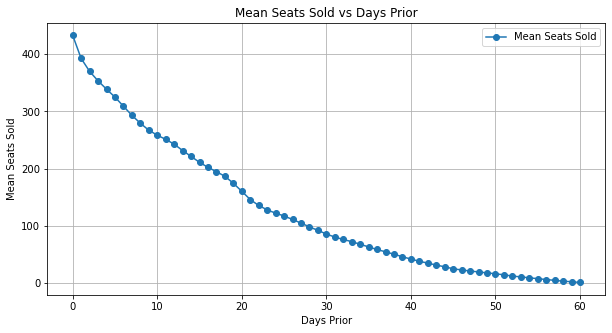

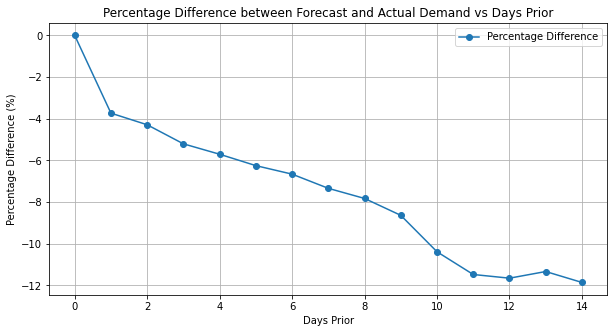

In [53]:
## This is our final attempt for the project with the MASE of 0.088

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 
# Step 1: Read the Data
airlineTrain = pd.read_csv('airline_data_training.csv')
airlineValid = pd.read_csv('airline_data_validation.csv')

 
# Processing the data
def process_data(data):

    # Convert the departure_date and booking_date to datetime objects
    data['departure_date'] = pd.to_datetime(data['departure_date'])
    data['booking_date'] = pd.to_datetime(data['booking_date'])

    # Calculate days_prior: departure_date - booking_date
    data['days_prior'] = (data['departure_date'] - data['booking_date']).dt.days

    # Calculate the week_day (on which day the departure_date is)
    data['week_day'] = data['departure_date'].dt.day_name()

    # Calculate the final_demand for a given departure date
    data['final_demand'] = data.groupby('departure_date')['cum_bookings'].transform(max)

    data = calculate_remaining_demand(data)

    data = calculate_booking_rate(data)

    return data


# Calculating the remaining_demand
def calculate_remaining_demand(data):
    
    # Sort the data by 'departure_date' and 'booking_date' in descending order
    data = data.sort_values(by=['departure_date', 'booking_date'], ascending=[True, True])

    # Add the 'remaining_demand' column
    data['remaining_demand'] = data.groupby('departure_date')['final_demand'].transform(max) - data['cum_bookings']

    return data

# Calculating the booking_rate
def calculate_booking_rate(data):

    # Group by 'days_prior' and 'week_day' and calculate the mean of 'cum_bookings'
    data['booking_rate'] = data.groupby(['days_prior', 'week_day'])['cum_bookings'].transform('mean') / data['final_demand']

    return data

 
# Example Usage:

processed_train_data = process_data(airlineTrain)

processed_valid_data = process_data(airlineValid)

 
# Part 2
## Additive model
def modified_additive_model(train_data, valid_data):

    # Define a modified custom weight function with normalization
    def custom_weight_function(x):
        weights = np.exp(-np.arange(1, len(x) + 1) ** 0.843)  # Exponentially decreasing weights with a higher power
        normalized_weights = weights / np.sum(weights)  # Normalize weights

        return np.sum(normalized_weights * x)

    # Calculate custom weighted averages for avg_remaining_demand
    train_data['avg_remaining_demand'] = (

        train_data.groupby(['days_prior', 'week_day'])['remaining_demand']

        .transform(custom_weight_function)
    )

 
    # Using avg_remaining_demand to generate predicted_rates for valid_data
    valid_data['days_prior'] = (valid_data['departure_date'] - valid_data['booking_date']).dt.days
    predicted_demand = valid_data.merge(train_data[['days_prior', 'week_day', 'avg_remaining_demand']].drop_duplicates(),
                                        how='left', on=['days_prior', 'week_day'])

 
    # Calculate the forecast for our model: model_forecast
    predicted_demand['model_forecast'] = predicted_demand['cum_bookings'] + predicted_demand['avg_remaining_demand']

 
    # Calculate error for our model
    predicted_demand['model_errors'] = abs(predicted_demand['final_demand'] - predicted_demand['model_forecast'])

    predicted_demand['naive_errors'] = abs(predicted_demand['final_demand'] - predicted_demand['naive_fcst'])

 
    # Calculate the model's total error
    total_error = predicted_demand['model_errors'].sum()

    n_total_error = predicted_demand['naive_fcst'].sum()

    MASE = total_error / n_total_error

    return total_error, n_total_error, predicted_demand

 

# Example Usage:
total_error, n_total_error, predicted_demand = modified_additive_model(processed_train_data, processed_valid_data)


# Calculate MASE outside the function
mase = total_error / n_total_error

 
print("Airline Booking Demand Forecast")
print("Predicted using Additive Model Technique")
print(f"MASE is: {mase}")


# Create a DataFrame for the forecast results

forecast_results = pd.DataFrame({
    'Departure Date': predicted_demand['departure_date'],
    'Booking Date': predicted_demand['booking_date'],
    'Forecasts': predicted_demand['model_forecast']

})


# Display the forecast results
print(forecast_results)

 
# Plotting the mean seats sold
plt.figure(figsize=(10, 5))

# Plot the mean seats sold
plt.plot(processed_train_data.groupby('days_prior')['cum_bookings'].mean(), marker='o', label='Mean Seats Sold')

# Specify labels and title
plt.xlabel('Days Prior')
plt.ylabel('Mean Seats Sold')
plt.title('Mean Seats Sold vs Days Prior')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the percentage difference between actual demand and forecast
predicted_demand['percentage_difference'] = ((predicted_demand['model_forecast'] - predicted_demand['final_demand']) / predicted_demand['final_demand']) * 100


# Plotting the percentage difference
plt.figure(figsize=(10, 5))


# Plot the percentage difference
plt.plot(predicted_demand.groupby('days_prior')['percentage_difference'].mean(), marker='o', label='Percentage Difference')


# Specify labels and title
plt.xlabel('Days Prior')
plt.ylabel('Percentage Difference (%)')
plt.title('Percentage Difference between Forecast and Actual Demand vs Days Prior')
plt.legend()
plt.grid(True)
plt.show()